In [3]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import sys
import seaborn as sns
from scipy import signal

import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [4]:
sys.path.append('/Users/kperks/mnt/engram/scripts/Python/Analysis/')
from ClassDef_AmplitudeShift_Stable import AmpShift_Stable

In [10]:
def compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur):
    
    marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')

    CmdTrig = expt.get_events('CmdTrig')

    #uncoupled
#     bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
    bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
    trial_df = expt.filter_marker_df_code(bout_df,['T'])

    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

    base_df = expt.filter_marker_df_code(bout_df,['U'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

    ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    trial_df.insert(np.shape(trial_df)[1],'ampshift_round',ampshift_round)

    trialmat = []
    for a in np.unique(trial_df['ampshift_round']):
        theseT = trial_df[trial_df['ampshift_round']==a].time.values
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        trialmat.append(np.mean(R,1))
    trialmat = np.asarray(trialmat).T
    trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

    plt.figure(figsize=(6,5))
    colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))
    for i,sweep in enumerate(trialmat.T):
        plt.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 3);
    plt.ylim(-10,20)

    dt = expt.get_dt('lowgain')
    Ramp_uc = np.asarray([np.max(sweep[int(0.002/dt):]) for sweep in trialmat.T])

    #coupled
#     bout_c = [expt.get_bout_win('N','Keyboard')[0],expt.get_bout_win('N','Keyboard')[1]]
    bout_df = expt.filter_marker_df_time(marker_df,bout_c)
    trial_df = expt.filter_marker_df_code(bout_df,['T'])

    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

    base_df = expt.filter_marker_df_code(bout_df,['C'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

    ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
    # ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)

    trialmat = []
    for a in np.unique(trial_df['ampshift']):
        theseT = trial_df[trial_df['ampshift']==a].time.values
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        trialmat.append(np.mean(R,1))
    trialmat = np.asarray(trialmat).T
    trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T
    
    cmd_df = expt.filter_marker_df_code(bout_df,['C'])
    cmd_t = np.asarray([CmdTrig[np.max(np.where(CmdTrig<stim_t)[0])] for stim_t in cmd_df['time'].values])
    C_latency = np.median(cmd_df.time.values-cmd_t)

    cmd_df = expt.filter_marker_df_code(bout_df,['U'])
    cmd_t = np.asarray([CmdTrig[np.max(np.where(CmdTrig<stim_t)[0])] for stim_t in cmd_df['time'].values])
    xtime,cmd_sweeps = expt.get_sweepsmat('lowgain',cmd_t+C_latency,sweepdur)
    cmd_R = np.mean(cmd_sweeps,1)-np.mean(cmd_sweeps,1)[0]

#     trialmat = np.asarray([sweep-cmd_R for sweep in trialmat.T]).T

    plt.figure(figsize=(6,5))
    colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))
    for i,sweep in enumerate(trialmat.T):
        plt.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 3);
    plt.ylim(-10,20)
    plt.plot(xtime,cmd_R,color = 'black')

    dt = expt.get_dt('lowgain')
    Ramp_c = np.asarray([np.max(sweep[int(0.002/dt):]) for sweep in trialmat.T])

    plt.figure(figsize = (4,5))
    plt.scatter(np.unique(trial_df['ampshift']),Ramp_uc,color = sns.xkcd_rgb['bright green'])
    plt.scatter(np.unique(trial_df['ampshift']),Ramp_c,color = sns.xkcd_rgb['bright orange'])
    plt.ylim(-2,20)
    plt.xlim(-45,45)
    
    return np.unique(trial_df['ampshift']),Ramp_uc,Ramp_c

def uncoupled_ampshift(expt,bout_uc,sweepdur):
    marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
    CmdTrig = expt.get_events('CmdTrig')

    #uncoupled
#     bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
    bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
    trial_df = expt.filter_marker_df_code(bout_df,['T'])

    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

    base_df = expt.filter_marker_df_code(bout_df,['U'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

    ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
    # ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)

    trialmat = []
    for a in np.unique(trial_df['ampshift']):
        theseT = trial_df[trial_df['ampshift']==a].time.values
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        trialmat.append(np.mean(R,1))
    trialmat = np.asarray(trialmat).T 
    trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

    plt.figure(figsize=(8,5))
    colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))
    for i,sweep in enumerate(trialmat.T):
        plt.plot(xtime,sweep,color = colinds[i],lw = 3);
    plt.ylim(-10,50)

    dt = expt.get_dt('lowgain')
    Ramp_uc = np.asarray([np.max(sweep[int(0.002/dt):]) for sweep in trialmat.T])
    
    plt.figure(figsize = (5,5))
    plt.scatter(np.unique(trial_df['ampshift']),Ramp_uc,color = sns.xkcd_rgb['bright green'])
    plt.ylim(-5,50)
    plt.xlim(-45,45)
    
    return np.unique(trial_df['ampshift']),Ramp_uc

def coupled_ampshift(expt,bout_c,sweepdur):    
    marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')
    CmdTrig = expt.get_events('CmdTrig')
    
    bout_df = expt.filter_marker_df_time(marker_df,bout_c)
    trial_df = expt.filter_marker_df_code(bout_df,['T'])

    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

    base_df = expt.filter_marker_df_code(bout_df,['C'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

    ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
    # ampshift, ampshift_round = expt.cluster_event_Amp(event_Amp,event_0_Amp)

    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)

    trialmat = []
    for a in np.unique(trial_df['ampshift']):
        theseT = trial_df[trial_df['ampshift']==a].time.values
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        trialmat.append(np.mean(R,1))
    trialmat = np.asarray(trialmat).T
    trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T
    
    cmd_df = expt.filter_marker_df_code(bout_df,['C'])
    cmd_t = np.asarray([CmdTrig[np.max(np.where(CmdTrig<stim_t)[0])] for stim_t in cmd_df['time'].values])
    C_latency = np.median(cmd_df.time.values-cmd_t)

    cmd_df = expt.filter_marker_df_code(bout_df,['U'])
    cmd_t = np.asarray([CmdTrig[np.max(np.where(CmdTrig<stim_t)[0])] for stim_t in cmd_df['time'].values])
    xtime,cmd_sweeps = expt.get_sweepsmat('lowgain',cmd_t+C_latency,sweepdur)
    cmd_R = np.mean(cmd_sweeps,1)-np.mean(cmd_sweeps,1)[0]

    trialmat = np.asarray([sweep-cmd_R for sweep in trialmat.T]).T

    plt.figure(figsize=(8,5))
    colinds = plt.cm.plasma(np.linspace(0.2,1,np.shape(trialmat)[1]))
    for i,sweep in enumerate(trialmat.T):
        plt.plot(xtime,sweep-sweep[0],color = colinds[i],lw = 3);
    plt.ylim(-10,50)

    dt = expt.get_dt('lowgain')
    Ramp_c = np.asarray([np.max(sweep[int(0.002/dt):]) for sweep in trialmat.T])

    plt.figure(figsize = (5,5))
    plt.scatter(np.unique(trial_df['ampshift']),Ramp_c,color = sns.xkcd_rgb['bright orange'])
    plt.ylim(-5,50)
    plt.xlim(-45,45)
    
    return np.unique(trial_df['ampshift']),Ramp_c

def calc_peaks(xtime,sweeps, order, min_peakt,threshold_h,dt):
    R = sweeps #np.mean(sweeps,1)-np.mean(sweeps,1)[0]
    
    nsamp=int(order/dt) #the window of comparison in nsamp for order; 2msec seemed good
    epsp_ = signal.argrelextrema(R,np.greater_equal,order = nsamp)[0]
    epsp_ = epsp_[np.where((epsp_*dt)>min_peakt)[0]]
    epsp = []
    measure = epsp_
    for i in measure:
        lb = int(min_peakt/dt)
        rb = len(R)-1
        min_height = np.min([abs(R[i]-R[lb]),abs(R[i]-R[rb])])
        if min_height>threshold_h:
            epsp.append(i)
    if len(epsp)>0:
        epsp = np.min(epsp)
    elif len(epsp)==0:
        epsp = np.NaN

    R_filt = R #signal.medfilt(R,[11])
    y = signal.medfilt(np.concatenate([[0],np.diff(R_filt)]),[25]) #-threshold_dvdt
    accel = signal.medfilt(np.concatenate([[0],np.diff(y)]),[11])   

    dvdt_start = int(0.002/dt)
    if ~np.isnan([epsp]).any():
        epsp_t = xtime[epsp]
        max_dvdt = np.max(y[dvdt_start:epsp])
        dvdt_threshold = np.max([0.01,0.15*max_dvdt])

        onset_options = np.where((np.sign(y-dvdt_threshold)>0) & (np.sign(accel)>=0))[0]
        valid_onsets = onset_options[(onset_options>dvdt_start)&(onset_options<epsp)]
        if len(valid_onsets) > 0:
            if (epsp_t-(np.min(valid_onsets)*dt)) > 0: #ensure that onset is before peak
                epsp_onset_ind = np.min(valid_onsets) #min after stim artifact
                epsp_amp = R[epsp]-R[epsp_onset_ind]
                epsp_onset = xtime[epsp_onset_ind]
            elif (epsp_t-(np.min(valid_onsets)*dt)) <= 0:
                epsp_t = np.NaN
                epsp_onset = np.NaN
                epsp_amp = 0
        elif len(valid_onsets)==0:
            epsp_t = np.NaN
            epsp_onset = np.NaN
            epsp_amp = 0
    elif np.isnan([epsp]).any():
        epsp_t = np.NaN
        epsp_onset = np.NaN
        epsp_amp = 0    

    return epsp_t, epsp_amp, epsp_onset



In [6]:
def calc_peaks(xtime,sweeps, order, min_peakt,threshold_h,dt):
    R = sweeps #np.mean(sweeps,1)-np.mean(sweeps,1)[0]
    
    nsamp=int(order/dt) #the window of comparison in nsamp for order; 2msec seemed good
    epsp_ = signal.argrelextrema(R,np.greater_equal,order = nsamp)[0]
    epsp_ = epsp_[np.where((epsp_*dt)>min_peakt)[0]]
    epsp = []
    measure = epsp_
    for i in measure:
        lb = int(min_peakt/dt)
        rb = len(R)-1
        min_height = np.min([abs(R[i]-R[lb]),abs(R[i]-R[rb])])
        if min_height>threshold_h:
            epsp.append(i)
    if len(epsp)>0:
        epsp = np.min(epsp)
    elif len(epsp)==0:
        epsp = np.NaN

    R_filt = R #signal.medfilt(R,[11])
    y = signal.medfilt(np.concatenate([[0],np.diff(R_filt)]),[25]) #-threshold_dvdt
    accel = signal.medfilt(np.concatenate([[0],np.diff(y)]),[11])   

    dvdt_start = int(0.002/dt)
    if ~np.isnan([epsp]).any():
        epsp_t = xtime[epsp]
        max_dvdt = np.max(y[dvdt_start:epsp])
        dvdt_threshold = np.max([0.01,0.15*max_dvdt])

        onset_options = np.where((np.sign(y-dvdt_threshold)>0) & (np.sign(accel)>=0))[0]
        valid_onsets = onset_options[(onset_options>dvdt_start)&(onset_options<epsp)]
        if len(valid_onsets) > 0:
            if (epsp_t-(np.min(valid_onsets)*dt)) > 0: #ensure that onset is before peak
                epsp_onset_ind = np.min(valid_onsets) #min after stim artifact
                epsp_amp = R[epsp]-R[epsp_onset_ind]
                epsp_onset = xtime[epsp_onset_ind]
            elif (epsp_t-(np.min(valid_onsets)*dt)) <= 0:
                epsp_t = np.NaN
                epsp_onset = np.NaN
                epsp_amp = 0
        elif len(valid_onsets)==0:
            epsp_t = np.NaN
            epsp_onset = np.NaN
            epsp_amp = 0
    elif np.isnan([epsp]).any():
        epsp_t = np.NaN
        epsp_onset = np.NaN
        epsp_amp = 0    

    return epsp_t, epsp_amp, epsp_onset

def get_fsl(expt,meta_u_df,exptname,stim_t):
    min_peakt = 0.002 #(s)
    threshold_h = 5 #(mV)
    order = 0.002 #(s)
    dt = expt.get_dt('lowgain')

    baseamp = 350

    sweepdur = 0.03
    basedur = 0.004

    stim_df = pd.DataFrame({})
    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',stim_t,eventDur)
    ampshift = np.asarray([np.round(((np.max(sweep)-350)/350)*100) for sweep in event_sweeps.T])

    stim_df.insert(np.shape(stim_df)[1],'ampshift',ampshift)

    xtime_,base = expt.get_sweepsmat('lowgain',stim_t-basedur,basedur)
    Vm = np.median(base,0)
    xtime,sweeps = expt.get_sweepsmat('lowgain',stim_t,sweepdur)
    fsl = []
    onset = []
    amp = []
    for sweep in sweeps.T:
        r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
        fsl.append(r_u[0])
        onset.append(r_u[2])
        amp.append(r_u[1])

    stim_df.insert(np.shape(stim_df)[1],'fsl',fsl)
    stim_df.insert(np.shape(stim_df)[1],'amp',amp)

    u = stim_df.groupby('ampshift',sort=True)['fsl'].mean()
    dict1 = {'exptname': exptname}
    for k,v in zip(u.keys(),u.values):
        dict1.update({str(k) : [v]})
    thisdf = pd.DataFrame.from_dict(dict1)
    thisdf = thisdf.set_index('exptname',drop=True)
    meta_u_df = meta_u_df.append(thisdf,sort = False,ignore_index = False)

    hfig = plt.figure(); ax = hfig.add_axes([0.1,0.1,0.8,0.8])
    ax.scatter(ampshift,fsl)
    ax.scatter(ampshift, onset)
    ax.set_ylim(2,15)
    hfig = plt.figure(); ax = hfig.add_axes([0.1,0.1,0.8,0.8])
    ax.scatter(fsl,amp)
    ax.set_ylim(0,45)
                                 
    return meta_u_df

In [7]:
exptpath = Path.cwd().resolve().parents[0] #assumes running notebook from /data_processed
data_folder = exptpath / 'data_raw'

/Users/kperks/mnt/engram/spikedata/data_raw/20200719/20200719_003.smr


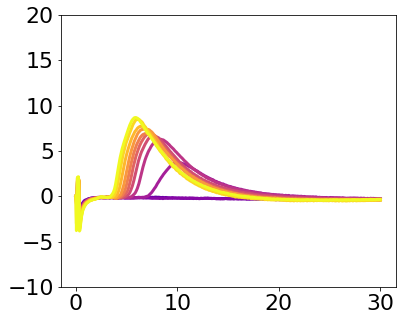

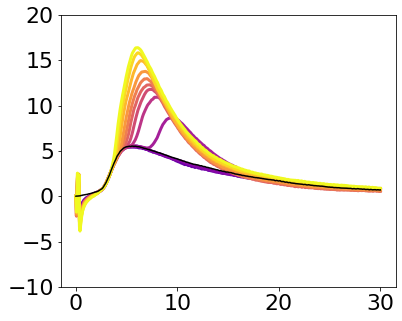

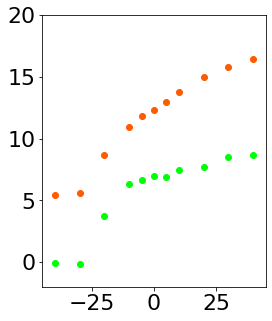

In [16]:
exptname = '20200719_003'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

# hyperpol so no spikes
########
bout_uc = [expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[1]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)



(-45, 45)

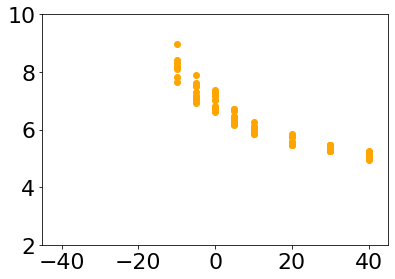

In [17]:
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

min_peakt = 0.002 #(s)
threshold_h = 20 #(mV)
order = 0.002 #(s)
dt = expt.get_dt('lowgain')

baseamp = 2.5
sweepdur = 0.03
basedur = 0.004
eventDur = 0.001

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trig_df = expt.filter_marker_df_code(bout_df,['T'])
trig_t = trig_df.time.values 

xtime,event_sweeps = expt.get_sweepsmat('SIU',trig_t,eventDur)
ampshift = np.asarray([np.round(((np.max(sweep)-baseamp)/baseamp)*100) for sweep in event_sweeps.T])

xtime,sweeps = expt.get_sweepsmat('lowgain',trig_t,sweepdur)
fsl = []
onset = []
amp = []
for sweep in sweeps.T:
    r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
    fsl.append(r_u[0])
    onset.append(r_u[2])
    amp.append(r_u[1])

ampshift_u = ampshift
fsl_u = fsl
amp_u = amp

bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trig_df = expt.filter_marker_df_code(bout_df,['T'])
trig_t = trig_df.time.values 

xtime,event_sweeps = expt.get_sweepsmat('SIU',trig_t,eventDur)
ampshift = np.asarray([np.round(((np.max(sweep)-baseamp)/baseamp)*100) for sweep in event_sweeps.T])

xtime,sweeps = expt.get_sweepsmat('lowgain',trig_t,sweepdur)
fsl = []
onset = []
amp = []
for sweep in sweeps.T:
    r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
    fsl.append(r_u[0])
    onset.append(r_u[2])
    amp.append(r_u[1])

ampshift_c = ampshift
fsl_c = fsl
amp_c = amp

hfig = plt.figure(); ax = hfig.add_axes([0.1,0.1,0.8,0.8])
ax.scatter(ampshift_u,fsl_u,color = 'green')
ax.scatter(ampshift_c,fsl_c,color = 'orange')
ax.set_ylim(2,10)
ax.set_xlim(-45,45)


/Users/kperks/mnt/engram/spikedata/data_raw/20200718/20200718_010.smr


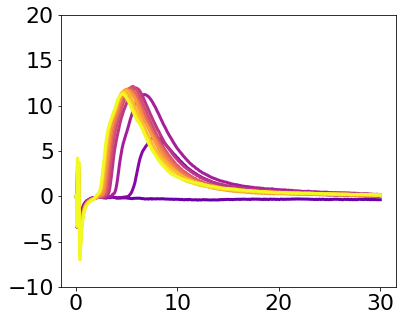

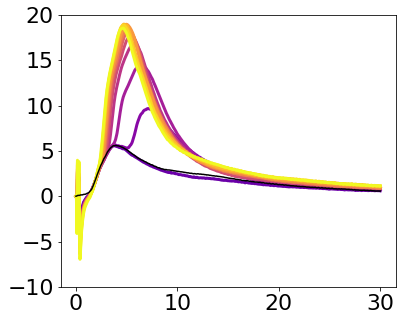

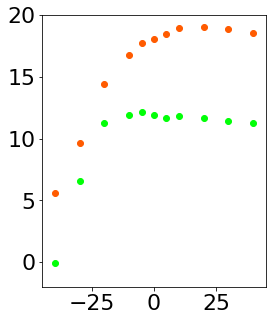

In [13]:
exptname = '20200718_010'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

# hyperpol so no spikes
########
bout_uc = [expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[1]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)



(-45, 45)

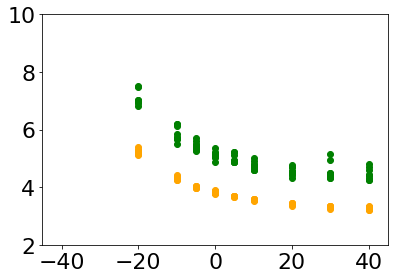

In [15]:
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

min_peakt = 0.002 #(s)
threshold_h = 20 #(mV)
order = 0.002 #(s)
dt = expt.get_dt('lowgain')

baseamp = 2.5
sweepdur = 0.03
basedur = 0.004
eventDur = 0.001

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trig_df = expt.filter_marker_df_code(bout_df,['T'])
trig_t = trig_df.time.values 

xtime,event_sweeps = expt.get_sweepsmat('SIU',trig_t,eventDur)
ampshift = np.asarray([np.round(((np.max(sweep)-baseamp)/baseamp)*100) for sweep in event_sweeps.T])

xtime,sweeps = expt.get_sweepsmat('lowgain',trig_t,sweepdur)
fsl = []
onset = []
amp = []
for sweep in sweeps.T:
    r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
    fsl.append(r_u[0])
    onset.append(r_u[2])
    amp.append(r_u[1])

ampshift_u = ampshift
fsl_u = fsl
amp_u = amp

bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trig_df = expt.filter_marker_df_code(bout_df,['T'])
trig_t = trig_df.time.values 

xtime,event_sweeps = expt.get_sweepsmat('SIU',trig_t,eventDur)
ampshift = np.asarray([np.round(((np.max(sweep)-baseamp)/baseamp)*100) for sweep in event_sweeps.T])

xtime,sweeps = expt.get_sweepsmat('lowgain',trig_t,sweepdur)
fsl = []
onset = []
amp = []
for sweep in sweeps.T:
    r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
    fsl.append(r_u[0])
    onset.append(r_u[2])
    amp.append(r_u[1])

ampshift_c = ampshift
fsl_c = fsl
amp_c = amp

hfig = plt.figure(); ax = hfig.add_axes([0.1,0.1,0.8,0.8])
ax.scatter(ampshift_u,fsl_u,color = 'green')
ax.scatter(ampshift_c,fsl_c,color = 'orange')
ax.set_ylim(2,10)
ax.set_xlim(-45,45)


/Users/kperks/mnt/engram/spikedata/data_raw/20200718/20200718_007.smr


(-45, 45)

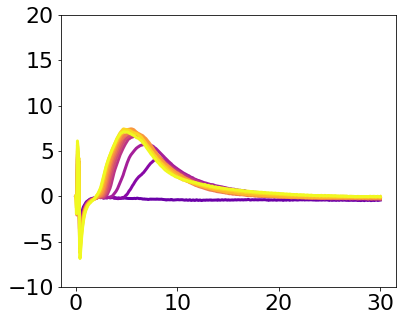

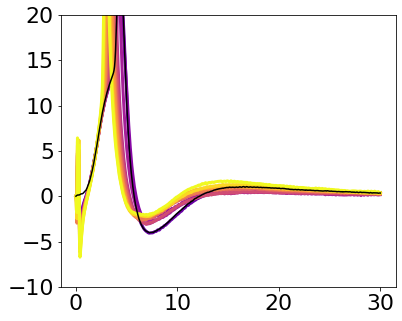

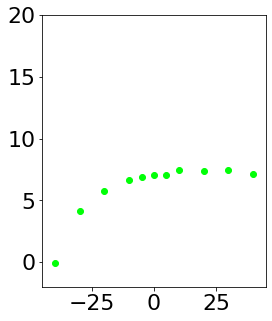

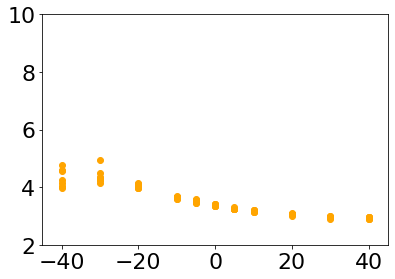

In [18]:
exptname = '20200718_007'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

# could not get to hyperpol with no spikes
########
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)


min_peakt = 0.002 #(s)
threshold_h = 20 #(mV)
order = 0.002 #(s)
dt = expt.get_dt('lowgain')

baseamp = 2.5
sweepdur = 0.03
basedur = 0.004
eventDur = 0.001

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trig_df = expt.filter_marker_df_code(bout_df,['T'])
trig_t = trig_df.time.values 

xtime,event_sweeps = expt.get_sweepsmat('SIU',trig_t,eventDur)
ampshift = np.asarray([np.round(((np.max(sweep)-baseamp)/baseamp)*100) for sweep in event_sweeps.T])

xtime,sweeps = expt.get_sweepsmat('lowgain',trig_t,sweepdur)
fsl = []
onset = []
amp = []
for sweep in sweeps.T:
    r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
    fsl.append(r_u[0])
    onset.append(r_u[2])
    amp.append(r_u[1])

ampshift_u = ampshift
fsl_u = fsl
amp_u = amp

bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trig_df = expt.filter_marker_df_code(bout_df,['T'])
trig_t = trig_df.time.values 

xtime,event_sweeps = expt.get_sweepsmat('SIU',trig_t,eventDur)
ampshift = np.asarray([np.round(((np.max(sweep)-baseamp)/baseamp)*100) for sweep in event_sweeps.T])

xtime,sweeps = expt.get_sweepsmat('lowgain',trig_t,sweepdur)
fsl = []
onset = []
amp = []
for sweep in sweeps.T:
    r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
    fsl.append(r_u[0])
    onset.append(r_u[2])
    amp.append(r_u[1])

ampshift_c = ampshift
fsl_c = fsl
amp_c = amp

hfig = plt.figure(); ax = hfig.add_axes([0.1,0.1,0.8,0.8])
ax.scatter(ampshift_u,fsl_u,color = 'green')
ax.scatter(ampshift_c,fsl_c,color = 'orange')
ax.set_ylim(2,10)
ax.set_xlim(-45,45)


/Users/kperks/mnt/engram/spikedata/data_raw/20200718/20200718_008.smr


(-45, 45)

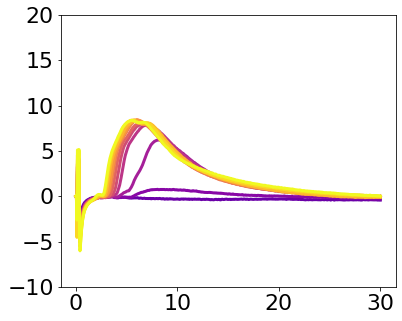

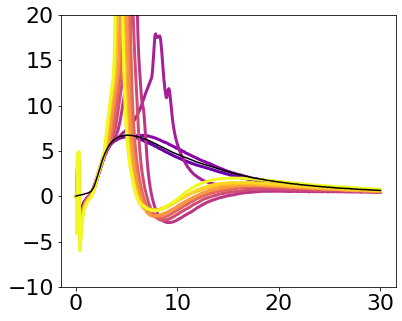

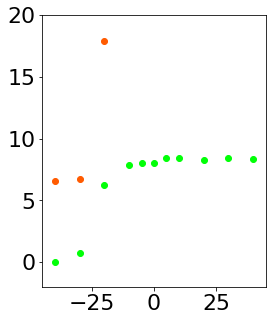

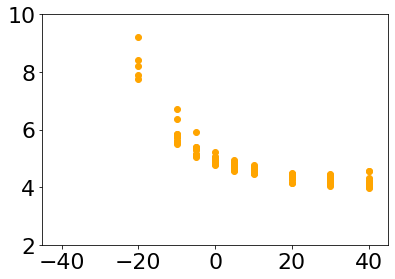

In [19]:
exptname = '20200718_008'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

# could not get to hyperpol with no spikes
########
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)


min_peakt = 0.002 #(s)
threshold_h = 20 #(mV)
order = 0.002 #(s)
dt = expt.get_dt('lowgain')

baseamp = 2.5
sweepdur = 0.03
basedur = 0.004
eventDur = 0.001

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trig_df = expt.filter_marker_df_code(bout_df,['T'])
trig_t = trig_df.time.values 

xtime,event_sweeps = expt.get_sweepsmat('SIU',trig_t,eventDur)
ampshift = np.asarray([np.round(((np.max(sweep)-baseamp)/baseamp)*100) for sweep in event_sweeps.T])

xtime,sweeps = expt.get_sweepsmat('lowgain',trig_t,sweepdur)
fsl = []
onset = []
amp = []
for sweep in sweeps.T:
    r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
    fsl.append(r_u[0])
    onset.append(r_u[2])
    amp.append(r_u[1])

ampshift_u = ampshift
fsl_u = fsl
amp_u = amp

bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trig_df = expt.filter_marker_df_code(bout_df,['T'])
trig_t = trig_df.time.values 

xtime,event_sweeps = expt.get_sweepsmat('SIU',trig_t,eventDur)
ampshift = np.asarray([np.round(((np.max(sweep)-baseamp)/baseamp)*100) for sweep in event_sweeps.T])

xtime,sweeps = expt.get_sweepsmat('lowgain',trig_t,sweepdur)
fsl = []
onset = []
amp = []
for sweep in sweeps.T:
    r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
    fsl.append(r_u[0])
    onset.append(r_u[2])
    amp.append(r_u[1])

ampshift_c = ampshift
fsl_c = fsl
amp_c = amp

hfig = plt.figure(); ax = hfig.add_axes([0.1,0.1,0.8,0.8])
ax.scatter(ampshift_u,fsl_u,color = 'green')
ax.scatter(ampshift_c,fsl_c,color = 'orange')
ax.set_ylim(2,10)
ax.set_xlim(-45,45)


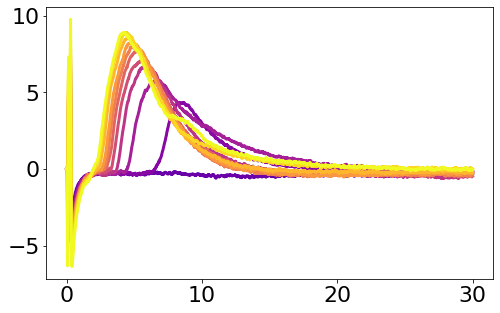

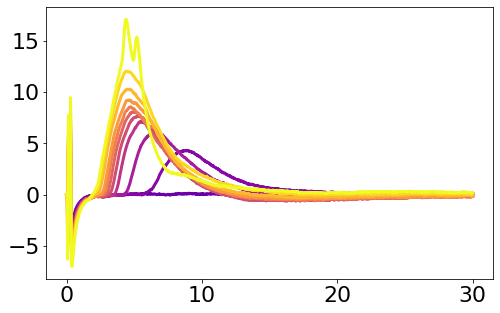

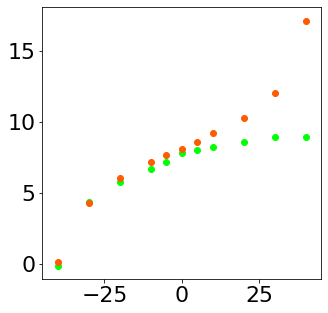

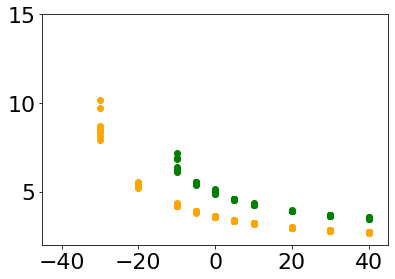

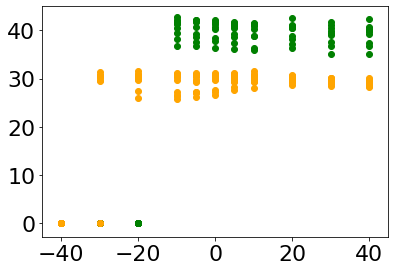

In [13]:
exptname = '20200525_003'
# expt = AmpShift_Stable()
# expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','SIU','spikes','DigMark')

marker_df = expt.get_marker_table() 

##### hyperpolarized
bout_uc = [expt.get_bout_win('R','Keyboard')[4]]
bout_c = [expt.get_bout_win('N','Keyboard')[2],
         expt.get_bout_win('N','Keyboard')[3]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

##### at rest
bout_uc = [expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]
# amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

min_peakt = 0.002 #(s)
threshold_h = 10 #(mV)
order = 0.002 #(s)
dt = expt.get_dt('lowgain')

baseamp = 2.5

sweepdur = 0.03
basedur = 0.004

eventDur = 0.001

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trig_df = expt.filter_marker_df_code(bout_df,['T'])
trig_t = trig_df.time.values 

xtime,event_sweeps = expt.get_sweepsmat('SIU',trig_t,eventDur)
ampshift = np.asarray([np.round(((np.max(sweep)-baseamp)/baseamp)*100) for sweep in event_sweeps.T])

xtime,sweeps = expt.get_sweepsmat('lowgain',trig_t,sweepdur)
fsl = []
onset = []
amp = []
for sweep in sweeps.T:
    r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
    fsl.append(r_u[0])
    onset.append(r_u[2])
    amp.append(r_u[1])

ampshift_u = ampshift
fsl_u = fsl
amp_u = amp

bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trig_df = expt.filter_marker_df_code(bout_df,['T'])
trig_t = trig_df.time.values 

xtime,event_sweeps = expt.get_sweepsmat('SIU',trig_t,eventDur)
ampshift = np.asarray([np.round(((np.max(sweep)-baseamp)/baseamp)*100) for sweep in event_sweeps.T])

xtime,sweeps = expt.get_sweepsmat('lowgain',trig_t,sweepdur)
fsl = []
onset = []
amp = []
for sweep in sweeps.T:
    r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
    fsl.append(r_u[0])
    onset.append(r_u[2])
    amp.append(r_u[1])

ampshift_c = ampshift
fsl_c = fsl
amp_c = amp


hfig = plt.figure(); ax = hfig.add_axes([0.1,0.1,0.8,0.8])
ax.scatter(ampshift_u,fsl_u,color = 'green')
ax.scatter(ampshift_c,fsl_c,color = 'orange')
ax.set_ylim(2,15)
ax.set_xlim(-45,45)
hfig = plt.figure(); ax = hfig.add_axes([0.1,0.1,0.8,0.8])
ax.scatter(ampshift_u,amp_u,color = 'green')
ax.scatter(ampshift_c,amp_c,color = 'orange')


/Users/kperks/mnt/engram/spikedata/data_raw/20200525/20200525_005.smr


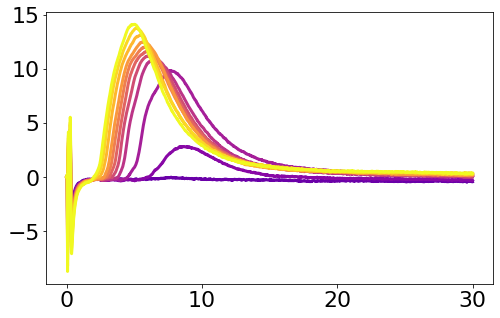

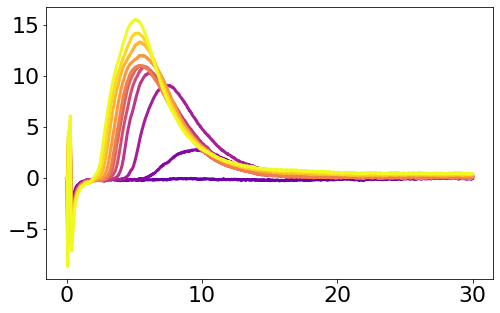

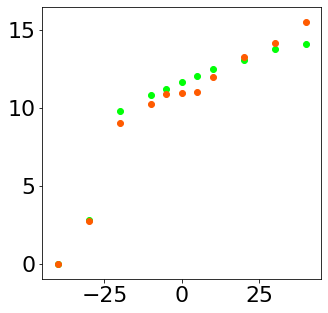

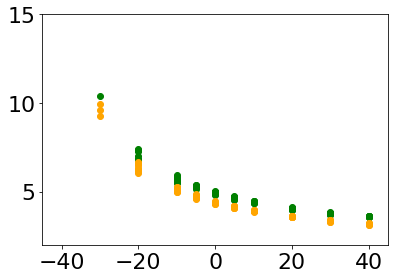

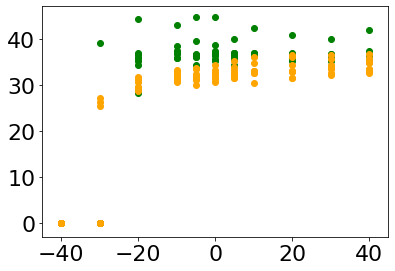

In [14]:
exptname = '20200525_005'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','SIU','spikes','DigMark')

marker_df = expt.get_marker_table() 

##### hyperpolarized
bout_uc = [expt.get_bout_win('R','Keyboard')[3]]
bout_c = [expt.get_bout_win('N','Keyboard')[3]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

##### at rest
bout_uc = [expt.get_bout_win('R','Keyboard')[4]]
bout_c = [expt.get_bout_win('N','Keyboard')[4]]
# amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

min_peakt = 0.002 #(s)
threshold_h = 10 #(mV)
order = 0.002 #(s)
dt = expt.get_dt('lowgain')

baseamp = 2.5

sweepdur = 0.03
basedur = 0.004

eventDur = 0.001

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trig_df = expt.filter_marker_df_code(bout_df,['T'])
trig_t = trig_df.time.values 

xtime,event_sweeps = expt.get_sweepsmat('SIU',trig_t,eventDur)
ampshift = np.asarray([np.round(((np.max(sweep)-baseamp)/baseamp)*100) for sweep in event_sweeps.T])

xtime,sweeps = expt.get_sweepsmat('lowgain',trig_t,sweepdur)
fsl = []
onset = []
amp = []
for sweep in sweeps.T:
    r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
    fsl.append(r_u[0])
    onset.append(r_u[2])
    amp.append(r_u[1])

ampshift_u = ampshift
fsl_u = fsl
amp_u = amp

bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trig_df = expt.filter_marker_df_code(bout_df,['T'])
trig_t = trig_df.time.values 

xtime,event_sweeps = expt.get_sweepsmat('SIU',trig_t,eventDur)
ampshift = np.asarray([np.round(((np.max(sweep)-baseamp)/baseamp)*100) for sweep in event_sweeps.T])

xtime,sweeps = expt.get_sweepsmat('lowgain',trig_t,sweepdur)
fsl = []
onset = []
amp = []
for sweep in sweeps.T:
    r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
    fsl.append(r_u[0])
    onset.append(r_u[2])
    amp.append(r_u[1])

ampshift_c = ampshift
fsl_c = fsl
amp_c = amp


hfig = plt.figure(); ax = hfig.add_axes([0.1,0.1,0.8,0.8])
ax.scatter(ampshift_u,fsl_u,color = 'green')
ax.scatter(ampshift_c,fsl_c,color = 'orange')
ax.set_ylim(2,15)
ax.set_xlim(-45,45)
hfig = plt.figure(); ax = hfig.add_axes([0.1,0.1,0.8,0.8])
ax.scatter(ampshift_u,amp_u,color = 'green')
ax.scatter(ampshift_c,amp_c,color = 'orange')


/Users/kperks/mnt/engram/spikedata/data_raw/20200525/20200525_004.smr


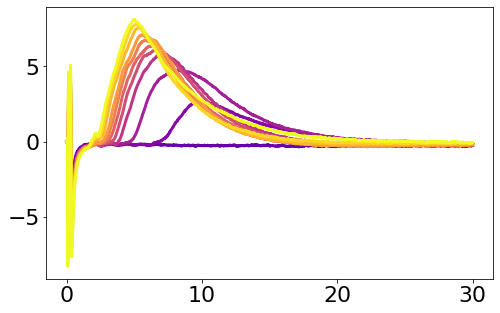

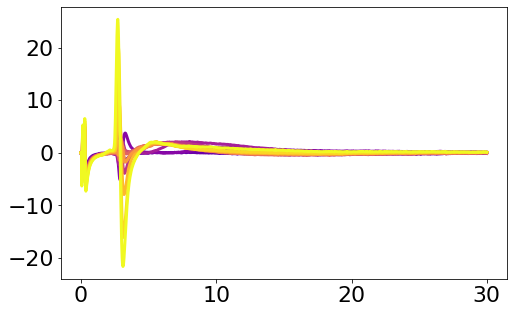

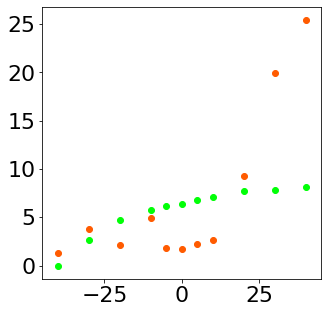

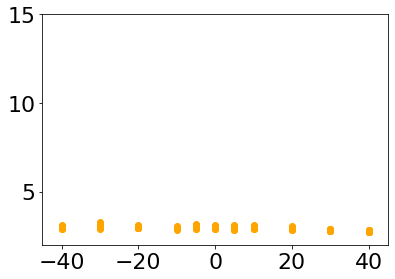

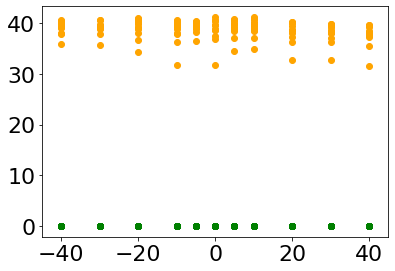

In [16]:
exptname = '20200525_004'
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','SIU','spikes','DigMark')

marker_df = expt.get_marker_table() 


##### at rest
bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

amp,Ramp_uc,Ramp_c = compare_coupled_uncoupled(expt,bout_c,bout_uc,sweepdur = 0.03)

min_peakt = 0.002 #(s)
threshold_h = 10 #(mV)
order = 0.002 #(s)
dt = expt.get_dt('lowgain')

baseamp = 2.5

sweepdur = 0.03
basedur = 0.004

eventDur = 0.001

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trig_df = expt.filter_marker_df_code(bout_df,['T'])
trig_t = trig_df.time.values 

xtime,event_sweeps = expt.get_sweepsmat('SIU',trig_t,eventDur)
ampshift = np.asarray([np.round(((np.max(sweep)-baseamp)/baseamp)*100) for sweep in event_sweeps.T])

xtime,sweeps = expt.get_sweepsmat('lowgain',trig_t,sweepdur)
fsl = []
onset = []
amp = []
for sweep in sweeps.T:
    r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
    fsl.append(r_u[0])
    onset.append(r_u[2])
    amp.append(r_u[1])

ampshift_u = ampshift
fsl_u = fsl
amp_u = amp

bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trig_df = expt.filter_marker_df_code(bout_df,['T'])
trig_t = trig_df.time.values 

xtime,event_sweeps = expt.get_sweepsmat('SIU',trig_t,eventDur)
ampshift = np.asarray([np.round(((np.max(sweep)-baseamp)/baseamp)*100) for sweep in event_sweeps.T])

xtime,sweeps = expt.get_sweepsmat('lowgain',trig_t,sweepdur)
fsl = []
onset = []
amp = []
for sweep in sweeps.T:
    r_u = calc_peaks(xtime,sweep, order, min_peakt,threshold_h,dt)
    fsl.append(r_u[0])
    onset.append(r_u[2])
    amp.append(r_u[1])

ampshift_c = ampshift
fsl_c = fsl
amp_c = amp


hfig = plt.figure(); ax = hfig.add_axes([0.1,0.1,0.8,0.8])
ax.scatter(ampshift_u,fsl_u,color = 'green')
ax.scatter(ampshift_c,fsl_c,color = 'orange')
ax.set_ylim(2,15)
ax.set_xlim(-45,45)
hfig = plt.figure(); ax = hfig.add_axes([0.1,0.1,0.8,0.8])
ax.scatter(ampshift_u,amp_u,color = 'green')
ax.scatter(ampshift_c,amp_c,color = 'orange')
